# Hourly PSDS - ROMY | FUR | TILT with FFBI

## Load Libraries

In [348]:
from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange, nanmedian, append
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm
from pathlib import Path

import os, sys
import pickle
import matplotlib.pyplot as plt

from andbro__store_as_pickle import __store_as_pickle

import warnings
warnings.filterwarnings('ignore')

In [349]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [535]:
## _____________________
## pressure data
# name, comp, app = "PROMY", "", ""
# name, comp, app = "FFBI", "BDF", ""
name, comp, app = "FFBI", "BDO", ""

## _____________________
## ROMY data
# name, comp, app = "ROMY", "BJZ", ""
# name, comp, app = "ROMY", "BJU", ""
# name, comp, app = "ROMY", "BJV", ""
# name, comp, app = "ROMY", "BJN", ""
# name, comp, app = "ROMY", "BJE", ""

## _____________________
## FUR data
# name, comp, app = "FUR", "BHZ", ""
# name, comp, app = "FUR", "BHN", ""
# name, comp, app = "FUR", "BHE", ""

## _____________________
## TILT data
# name, comp, app = "DROMY", "LAN", ""
# name, comp, app = "DROMY", "LAE", ""
# name, comp, app = "DROMY", "LAT", ""


## _____________________
## coherence data
# name, comp, app = "ROMY", "BJZ", "_coherence"
# name, comp, app = "ROMY", "BJU", "_coherence"
# name, comp, app = "ROMY", "BJV", "_coherence"
# name, comp, app = "ROMY", "BJN", "_coherence"
# name, comp, app = "ROMY", "BJE", "_coherence"

# name, comp, app = "FUR", "BHZ", "_coherence"
# name, comp, app = "FUR", "BHN", "_coherence"
# name, comp, app = "FUR", "BHE", "_coherence"

# name, comp, app = "DROMY", "LAN", "_coherence"
# name, comp, app = "DROMY", "LAE", "_coherence"

name0 = "BDO"

In [536]:
config = {}

config['year'] = "2023"

config['path'] = data_path+f"LNM2/PSDS/"

config['startdate'], config['enddate'] = "2023-09-23", "2023-09-30"

## specify paths
config['outpath_figures'] = data_path+f"LNM2/figures/"

config['path_to_outdata'] = data_path+f"LNM2/data/"

if "coherence" in app:
    config['filename'] = f"{name}{app}/{config['year']}_FFBI_{name0}_{name}_{comp}_3600"
    config['outname'] = f"{name}_{comp}_coherence"
else:
    config['filename'] = f"{name}{app}/{config['year']}_{name}_{comp}_3600"
    config['outname'] = f"{name}_{comp}"

## Methods

In [537]:
def __load_data_file(path, file):

    from tqdm.notebook import tqdm
    from numpy import array

    psds_all = []

    file = read_pickle(path+file)

    try:
        psds = file['psd']
    except:
        psds = file['coherence']

    ff = file['frequencies']

    for psd in psds:
        psds_all.append(psd)

    return ff, array(psds_all)

## Compute PSD value per frequency band

In [538]:
d1, d2 = config['startdate'], config['enddate']

psds_medians_out, times_out = [], []

# ff = pickle.load(open(config['path']+f"{config['filename']}_frequency_axis.pkl", 'rb'))

dat, dates = [], []
for jj, day in enumerate(date_range(d1, d2)):

#     if jj > 1:
#         continue

    day = str(day).split(" ")[0].replace("-", "")

    print(f"{config['filename']}_{day}_hourly.pkl")

    try:
        ff, _dat = __load_data_file(config['path'], f"{config['filename']}_{day}_hourly.pkl")
        # _dat, _rejected = __remove_noisy_psds(_dat, threshold_mean=1e-15, ff=ff1, flim=0.1)

    except Exception as e:
        # print(e)
        print(f" -> {day}: no data found")
        continue

    for _k, _psd in enumerate(_dat):
        dat.append(_psd)
        dates.append(f"{day}_{str(_k).rjust(2, '0')}")

dat = array(dat)

FFBI/2023_FFBI_BDO_3600_20230923_hourly.pkl
FFBI/2023_FFBI_BDO_3600_20230924_hourly.pkl
FFBI/2023_FFBI_BDO_3600_20230925_hourly.pkl
FFBI/2023_FFBI_BDO_3600_20230926_hourly.pkl
FFBI/2023_FFBI_BDO_3600_20230927_hourly.pkl
FFBI/2023_FFBI_BDO_3600_20230928_hourly.pkl
FFBI/2023_FFBI_BDO_3600_20230929_hourly.pkl
FFBI/2023_FFBI_BDO_3600_20230930_hourly.pkl


In [539]:
_dat = read_pickle(config['path']+"FUR_coherence/2023_FFBI_BDO_FUR_BHZ_3600_20230923_hourly.pkl")

### Get frequency bands

In [540]:
from functions.get_octave_bands import __get_octave_bands

In [541]:
f_lower, f_upper, f_center = __get_octave_bands(1e-3, 1e0, faction_of_octave=12, plot=False)

### Get PSD average for frequency bands

In [542]:
def __get_band_average(freq, data, f_center, f_upper, f_lower):

    ## get frequency indices
    fl_idx, fu_idx = [], []

    for _k, (fl, fu) in enumerate(zip(f_lower, f_upper)):
        if _k <= len(f_center):

            for _i, _f in enumerate(freq):
                if _f >= fl:
                    fl_idx.append(int(_i))
                    break

            for _i, _f in enumerate(freq):
                if _f >= fu:
                    fu_idx.append(int(_i))
                    break

    ## compute average per band
    psd_avg, fc, fu, fl = [], [], [], []
    for _n, (ifl, ifu) in enumerate(zip(fl_idx, fu_idx)):

        avg = []
        for _psd in data:
            avg.append(nanmedian(_psd[ifl:ifu]))

        psd_avg.append(array(avg))
        fc.append(f_center[_n])
        fu.append(f_upper[_n])
        fl.append(f_lower[_n])

    psd_avg = array(psd_avg)


    ## check up plot
    plt.figure(figsize=(15, 5))

    for _j, dd in enumerate(psd_avg):
        plt.scatter(ones(len(dd))*fc[_j], dd, s=5)
        plt.xscale("log")
        if not "_coherence" in app:
            plt.yscale("log")
        else:
            plt.ylim(0, 1.1)

    plt.show();


    ## output
    out = {}
    out['psd_avg'] = psd_avg
    out['fcenter'] = array(fc)
    out['fupper'] = array(fu)
    out['flower'] = array(fl)
    out['dates'] = dates

    return out

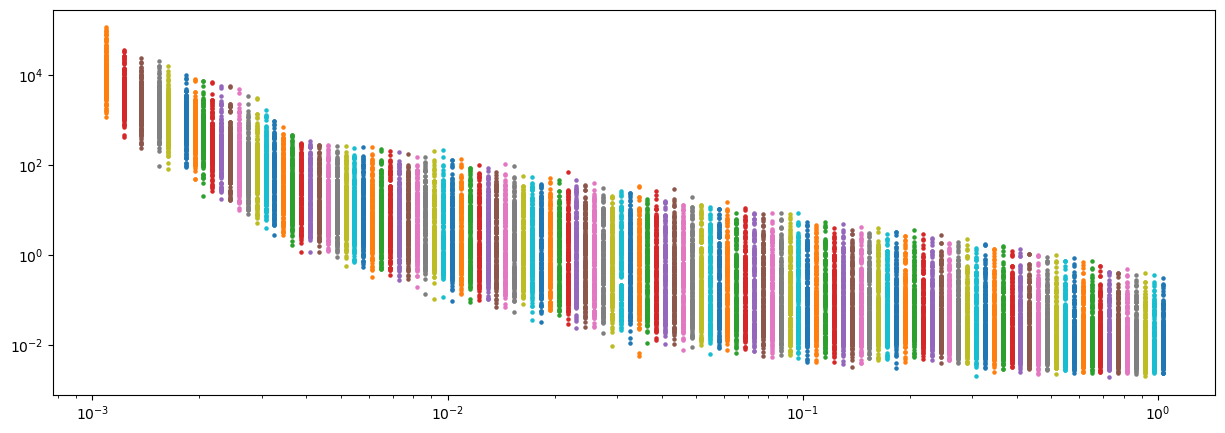

In [543]:
out0 = __get_band_average(ff, dat, f_center, f_upper, f_lower)

## Store data

In [544]:
## create and fill data frame
_df_out = DataFrame()

_df_out['dates'] = out0['dates']

for _i, fc in enumerate(out0['fcenter']):
    _df_out[round(fc, 5)] = out0['psd_avg'][_i]

df_out = _df_out.copy()

## store as pickle file
df_out.to_pickle(config['path_to_outdata']+config['outname']+".pkl")

## Plot Density Histogram

In [14]:
from functions.get_hist_loglog import __get_hist_loglog

In [304]:
# out = __get_hist_loglog(dat, ff, bins=100, density=False, axis=1, plot=True)

In [328]:

import matplotlib.pyplot as plt
import pickle
import os
import sys

from obspy import UTCDateTime, read, read_inventory
from obspy.signal.rotate import rotate2zne
from numpy import log10, zeros, append, linspace, mean, median, array, where, transpose, shape, histogram
from pandas import DataFrame, concat, Series, date_range, to_pickle
from pathlib import Path
from scipy.signal import coherence, welch

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml

import warnings
warnings.filterwarnings('ignore')


if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

# In[] ___________________________________________________________
''' ---- set variables ---- '''

config = {}


config['year'] = 2023


config['seed1'] = "BW.FFBI..BDO"  ## F = infrasound | O = absolute


config['seed2'] = "GR.FUR..BHZ"

config['date1'] = UTCDateTime(f"{config['year']}-09-23")
config['date2'] = UTCDateTime(f"{config['year']}-09-23")

config['path_to_data1'] = bay_path+f"mseed_online/archive/"
config['path_to_inv1'] = root_path+"Documents/ROMY/ROMY_infrasound/station_BW_FFBI.xml"

if "FUR" in config['seed2']:
    config['path_to_data2'] = bay_path+f"mseed_online/archive/"
    config['path_to_inv2'] = root_path+"Documents/ROMY/stationxml_ringlaser/dataless.seed.GR_FUR"
elif "ROMY" in config['seed2']:
    config['path_to_data2'] = archive_path+f"romy_archive/"
    config['path_to_inv2'] = root_path+"Documents/ROMY/stationxml_ringlaser/dataless.seed.BW_ROMY"


## specify unit
config['unit'] = "Pa" ## hPa or Pa or None

config['interval_seconds'] = 3600 ## in seconds
config['interval_overlap'] = 0  ## in seconds

## __________________________
## choose psd method
config['mode'] = "multitaper"  ## "multitaper" | "welch"

## __________________________
## set welch and coherence settings

config['taper'] = 'hann'
config['tseconds'] = 3600 ## seconds
config['toverlap'] = 0 ## 0.75
config['nfft'] = None
config['detrend'] = 'constant'
config['scaling'] = 'density'
config['onesided'] = True
config['frequency_limits'] = None # (0, 0.05) # in Hz

## __________________________
## set multitaper settings

## number of taper for multitaper to use
config['n_taper'] = 5


config['sta1'] = config['seed1'].split(".")[1]
config['sta2'] = config['seed2'].split(".")[1]

config['cha1'] = config['seed1'].split(".")[3]
config['cha2'] = config['seed2'].split(".")[3]

config['outname1'] = f"{config['year']}_{config['sta1']}_{config['cha1']}_{config['interval_seconds']}"
config['outname2'] = f"{config['year']}_{config['sta2']}_{config['cha2']}_{config['interval_seconds']}"
config['outname3'] = f"{config['year']}_{config['sta1']}_{config['cha1']}_{config['sta2']}_{config['cha2']}_{config['interval_seconds']}"

config['outpath1'] = data_path+f"LNM2/PSDS/{config['sta1']}/"
config['outpath2'] = data_path+f"LNM2/PSDS/{config['sta2']}/"
config['outpath3'] = data_path+f"LNM2/PSDS/{config['sta2']}_coherence/"

## tiltmeter configurations
confTilt = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/", "tiltmeter.conf")


# In[] ___________________________________________________________
'''---- define methods ----'''

def __multitaper_psd(arr, dt, n_win=5, time_bandwidth=4.0):

    import multitaper as mt

    out_psd = mt.MTSpec(arr, nw=time_bandwidth, kspec=n_win, dt=dt, iadapt=0)

    _f, _psd = out_psd.rspec()

    f = _f.reshape(_f.size)
    psd = _psd.reshape(_psd.size)


    return f, psd



def __write_to_csv(data, text, config):

    import csv

    opath = config['outpath']
    oname = config['outname']+"_"+text+"_psd.csv"

    # open the file in the write mode
    with open(opath+oname, 'w') as file:

        writer = csv.writer(file)
        for row in data:
            writer.writerow(row)

    if Path(opath+oname).exists():
        print(f"created: {opath}{oname}")


def __save_to_pickle(obj, path, name):

    ofile = open(path+name+".pkl", 'wb')
    pickle.dump(obj, ofile)

    if Path(path+name+".pkl").exists():
        print(f"\n -> created:  {path}{name}.pkl")


def __get_time_intervals(tbeg, tend, interval_seconds, interval_overlap):

    from obspy import UTCDateTime

    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    times = []
    t1, t2 = tbeg, tbeg + interval_seconds
    while t2 <= tend:
        times.append((t1, t2))
        t1 = t1 + interval_seconds - interval_overlap
        t2 = t2 + interval_seconds - interval_overlap

    return times


def __conversion_to_tilt(st, conf):

    st0 = st.copy()

    def convertTemp(trace):
        Tvolt = trace.data * conf.get('gainTemp')
        coeff = conf.get('calcTempCoefficients')
        return coeff[0] + coeff[1]*Tvolt + coeff[2]*Tvolt**2 + coeff[3]*Tvolt**3

    def convertTilt(trace, conversion, sensitivity):
        return trace.data * conversion * sensitivity

    for tr in st0:
        if tr.stats.channel[-1] == 'T':
            tr.data = convertTemp(tr)
        elif tr.stats.channel[-1] == 'N':
            tr.data = convertTilt(tr, conf['convTN'], conf['gainTilt'])
        elif tr.stats.channel[-1] == 'E':
            tr.data = convertTilt(tr, conf['convTE'], conf['gainTilt'])
        else:
            print("no match")

    print(f"  -> converted data of {st[0].stats.station}")
    return st0


# In[] ___________________________________________________________


days = int((config['date2'] - config['date1'])/86400)+1

if not Path(config['outpath1']).exists():
    Path(config['outpath1']).mkdir()
    print(f" -> created {config['outpath1']}")

if not Path(config['outpath2']).exists():
    Path(config['outpath2']).mkdir()
    print(f" -> created {config['outpath2']}")


minimum_collection = []
minimal_collection = []
columns = []
medians, dd = [], []

for date in date_range(str(config['date1'].date), str(config['date2'].date), days):

    print(f"\nprocessing  {str(date)[:10]}...")


    ## load data for the entire day
    config['tbeg'] = UTCDateTime(date)
    config['tend'] = UTCDateTime(date) + 86400

    try:
        st1 = __read_sds(config['path_to_data1'], config['seed1'], config['tbeg']-1800, config['tend']+1800)
        st2 = __read_sds(config['path_to_data2'], config['seed2'], config['tbeg']-1800, config['tend']+1800)
    except:
        print(f" -> failed to load data ...")
        continue



    ## read inventories
    try:
        inv1 = read_inventory(config['path_to_inv1'])
        inv2 = read_inventory(config['path_to_inv2'])
    except:
        print(f" -> failed to load inventory ...")
        continue

    if "BW.ROMY" in config['seed2'] and "Z" not in config['seed2']:
        try:
            _stU = __read_sds(config['path_to_data2'], "BW.ROMY..BJU", config['tbeg']-10, config['tend']+10)
            _stV = __read_sds(config['path_to_data2'], "BW.ROMY..BJV", config['tbeg']-10, config['tend']+10)
            _stZ = __read_sds(config['path_to_data2'], "BW.ROMY.10.BJZ", config['tbeg']-10, config['tend']+10)

            print(_stU, _stV, _stZ)

            ori_z = inv2.get_orientation("BW.ROMY.10.BJZ")
            ori_u = inv2.get_orientation("BW.ROMY..BJU")
            ori_v = inv2.get_orientation("BW.ROMY..BJV")

            romy_z, romy_n, romy_e = rotate2zne(
                                               _stZ[0].data, ori_z['azimuth'], ori_z['dip'],
                                               _stU[0].data, ori_u['azimuth'], ori_u['dip'],
                                               _stV[0].data, ori_v['azimuth'], ori_v['dip'],
                                               inverse=False
                                              )

            if "N" in config['seed2']:
                _stU[0].data = romy_n
                st2 = _stU.copy()
                # st2.select(channel="*U")[0].stats.channel = "BJN"

            elif "E" in config['seed2']:
                _stV[0].data = romy_e
                st2 = _stV.copy()
                # st2.select(channel="*V")[0].stats.channel = "BJE"

        except Exception as e:
            print(e)
            print(f" -> failed to rotate ROMY ...")
            continue


    if len(st1) > 1:
        st1.merge()
    if len(st2) > 1:
        st2.merge()

    if len(st1) == 0 or len(st2) == 0:
        print(st1)
        print(st2)
        continue

    ## conversion
    if "O" in st1[0].stats.channel:

        if config['unit'] == "Pa":
            for tr in st1:
                tr.data = tr.data *1.589e-6 *1e5   # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity_mb2005 = 1 mV/hPa
        elif config['unit'] == "hPa":
            for tr in st1:
                tr.data = tr.data *1.589e-6 *1e3   # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity_mb2005 = 1 mV/hPa



    elif "F" in st1[0].stats.channel:
#            for tr in st1:
#                tr.data = tr.data *1.589e-6 /0.02  # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity_mb2005=0.02 V/Pa
        st1 = st1.remove_response(inv1, water_level=10)

    if "J" in st2[0].stats.channel:
        st2 = st2.remove_sensitivity(inv2)

    elif "H" in st2[0].stats.channel:
        st2 = st2.remove_response(inv2, output="ACC", water_level=10)

    elif "A" in st2[0].stats.channel:
        st2 = __conversion_to_tilt(st2, confTilt["BROMY"])

    ## Pre-Processing
    try:
        st1 = st1.split()
        st2 = st2.split()


        if "BW.DROMY" in config['seed2']:
            st2 = st2.filter("lowpass", freq=0.25, corners=4, zerophase=True)
            st2 = st2.decimate(2, no_filter=True) ## 1 -> 0.5 Hz

            st1 = st1.filter("lowpass", freq=0.25, corners=4, zerophase=True)
            st1 = st1.decimate(2, no_filter=True) ## 40 -> 20 Hz
            st1 = st1.decimate(2, no_filter=True) ## 20 -> 10 Hz
            st1 = st1.decimate(2, no_filter=True) ## 10 -> 5 Hz
            st1 = st1.decimate(5, no_filter=True) ## 5 -> 1 Hz
            st1 = st1.decimate(2, no_filter=True) ## 1 -> 0.5 Hz

            ## convert tilt to acceleration
            for tr in st2:
                tr.data = tr.data*9.81

        else:

            # st1.detrend("demean")
            # st2.detrend("demean")
            # st1.taper(0.01)
            # st2.taper(0.01)

            st1 = st1.filter("lowpass", freq=5, corners=4, zerophase=True)
            st2 = st2.filter("lowpass", freq=5, corners=4, zerophase=True)

            st1 = st1.decimate(2, no_filter=True) ## 40 -> 20 Hz
            st1 = st1.decimate(2, no_filter=True) ## 40 -> 20 Hz
            st2 = st2.decimate(2, no_filter=True) ## 40 -> 20 Hz
            # st1 = st1.resample(20.0, no_filter=False)
            # st2 = st2.resample(20.0, no_filter=False)


        st1 = st1.merge()
        st2 = st2.merge()

        st1 = st1.trim(config['tbeg'], config['tend'])
        st2 = st2.trim(config['tbeg'], config['tend'])

    except Exception as e:
        print(e)
        print(f" -> pre-processing failed!")
        continue

    # st1.plot(equal_scale=False);
    # st2.plot(equal_scale=False);

    ## prepare time intervals
    times = __get_time_intervals(config['tbeg'], config['tend'], config['interval_seconds'], config['interval_overlap'])

    ## prepare psd parameters
    config['nperseg'] = int(st1[0].stats.sampling_rate*config.get('tseconds'))
    config['noverlap'] = int(0.5*config.get('nperseg'))


    print(st1)
    print(st2)


    if len(st1[0].data) != len(st2[0].data):
        print(" -> not sampe amount of samples!")
        continue


    ## run operations for time intervals
    for n, (t1, t2) in enumerate(times):

        ## trim streams for current interval
        _st1 = st1.copy().trim(t1, t2, nearest_sample=False)
        _st2 = st2.copy().trim(t1, t2, nearest_sample=False)

#            print("st: ", _st1[0].data.size, _st2[0].data.size)

        if n == 0:
            ## prepare lists
            if config['mode'] == "welch":
                psds1 = zeros([len(times), int(config.get('nperseg')/2)+1])
                psds2 = zeros([len(times), int(config.get('nperseg')/2)+1])
                cohs = zeros([len(times), int(config.get('nperseg')/2)+1])
            elif config['mode'] == "multitaper":
                # psds1 = zeros([len(times), int((config['interval_seconds']*20))])
                # psds2 = zeros([len(times), int((config['interval_seconds']*20))])
                # cohs = zeros([len(times), int(config.get('nperseg')/2)])
                psds1 = zeros([len(times), int(_st1[0].stats.npts)+1])
                psds2 = zeros([len(times), int(_st2[0].stats.npts)+1])
                cohs = zeros([len(times), int(config.get('nperseg')/2)+1])


        ## compute power spectra
        if config['mode'] == "welch":

            f1, psd1 = welch(
                            _st1[0].data,
                            fs=_st1[0].stats.sampling_rate,
                            window=config.get('taper'),
                            nperseg=config.get('nperseg'),
                            noverlap=config.get('noverlap'),
                            nfft=config.get('nfft'),
                            detrend=config.get('detrend'),
                            return_onesided=config.get('onesided'),
                            scaling=config.get('scaling'),
                           )

            f2, psd2 = welch(
                            _st2[0].data,
                            fs=_st2[0].stats.sampling_rate,
                            window=config.get('taper'),
                            nperseg=config.get('nperseg'),
                            noverlap=config.get('noverlap'),
                            nfft=config.get('nfft'),
                            detrend=config.get('detrend'),
                            return_onesided=config.get('onesided'),
                            scaling=config.get('scaling'),
                           )


processing  2023-09-23...
1 Trace(s) in Stream:
BW.FFBI..BDO | 2023-09-23T00:00:00.005000Z - 2023-09-24T00:00:00.005000Z | 10.0 Hz, 864001 samples
1 Trace(s) in Stream:
GR.FUR..BHZ | 2023-09-22T23:59:59.989999Z - 2023-09-23T23:59:59.989999Z | 10.0 Hz, 864001 samples


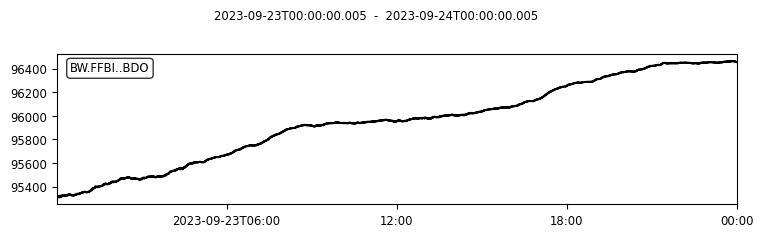

In [329]:
st1.plot();

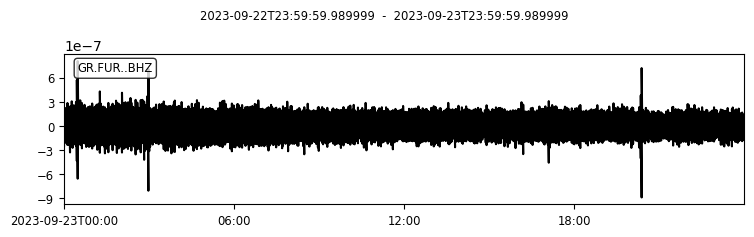

In [330]:
st2.plot();

(36001, 36002, 36002, 0.0)

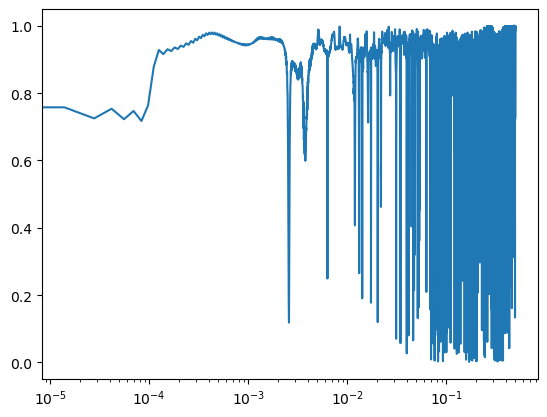

In [347]:


from multitaper import MTCross, MTSpec

f1, psd1 = __multitaper_psd(_st1[0].data, _st1[0].stats.delta, n_win=config.get("n_taper"), time_bandwidth=3)

f2, psd2 = __multitaper_psd(_st2[0].data, _st2[0].stats.delta, n_win=config.get("n_taper"), time_bandwidth=3)

psds1[n] = psd1
psds2[n] = psd2

# _st1.detrend("demean")
# _st1.filter("bandpass", freqmin=0.001, freqmax=5.0, corners=4, zerophase=True)
# _st1.plot();

# _st2.detrend("demean")
# _st2.filter("bandpass", freqmin=0.001, freqmax=5.0, corners=4, zerophase=True)
# _st2.plot();

x = _st1[0].data
y = _st2[0].data
dt = _st1[0].stats.delta

P1 = MTSpec(x, 4, 5, dt)
P2 = MTSpec(y, 4, 5, dt)

Pxy  = MTCross(P1, P2, wl=0.001)

from numpy.fft import fft

N = Pxy.freq.size

fxy_new, pxy_new = Pxy.freq[:,0][:N//2+1], Pxy.cohe[:,0][:N//2+1]

# plt.semilogx(dcohe[len(dcohe)//2:])
plt.semilogx(fxy_new, pxy_new)
# plt.semilogx(Pxy.freq[:,0], Pxy.cohe[:,0])

psd1.size, fxy_new.size, pxy_new.size, fxy_new[0]

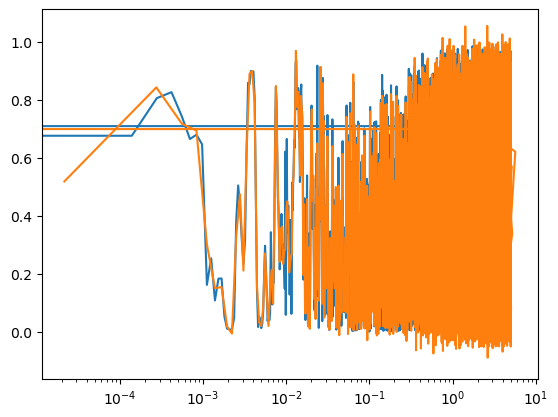

In [332]:
from scipy.signal import resample_poly

pxy_new = resample_poly(Pxy.cohe, 2, 4)

fxy_new = resample_poly(Pxy.freq, 2, 4)

plt.semilogx(Pxy.freq, Pxy.cohe)
plt.semilogx(fxy_new, pxy_new)

In [333]:
plt.semilogx(Pxy.freq[:N//2], np.unwrap(np.deg2rad(Pxy.phase[:N//2])))

NameError: name 'np' is not defined

In [ ]:
from gwpy.timeseries import TimeSeriesDict
from pandas import DataFrame
from gwpy.timeseries import TimeSeries

dat1 = TimeSeries(_st1[0].data, t0=0, dt=0.1, channel="d1")
dat2 = TimeSeries(_st2[0].data, t0=0, dt=0.1, channel="d2")

# coh = dat1.coherence_spectrogram(dat2, 10, fftlength=1/1000, overlap=.25)

In [ ]:
plot = coh.plot()
ax = plot.gca()
ax.set_ylabel('Frequency [Hz]')
ax.set_yscale('log')
ax.set_ylim(10, 8000)
ax.set_title(
    'Coherence between PSL periscope motion and LIGO-Hanford strain data',
)
ax.grid(True, 'both', 'both')
ax.colorbar(label='Coherence', clim=[0, 1], cmap='plasma')
plot.show()